In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
#from category_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score,accuracy_score, recall_score, precision_score

In [2]:
df = pd.read_csv('train.csv')

In [3]:
# Visualizando as primeiras linhas
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Vamos retirar a coluna PassengerId
df.drop('PassengerId', axis=1, inplace=True)

In [5]:
# Visualizando algumas informações sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


O nosso conjunto de dados é composto por 891 linha e 11 colunas, dentre essas colunas temos dados categóricos e numéricos. A coluna que queremos prever, `Survived`, é um dado binário (0, 1) onde, o valor 1 representa que a pessoa sobreviveu e o 0 não sobreviveu.

In [6]:
# Procurando valores nulos
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# Checando linhas duplicadas
df.duplicated().sum()

0

O nosso dataset não possui linhas duplicadas, porém possui 3 colunas (Age, Cabin, Embarked) com alguns valores nulos.

In [8]:
# Dividindo os dados em X e y
target = 'Survived'

# Variáveis preditoras
X = df.drop(target, axis=1).copy()

# Variável que queremos prever
y = df[target]

In [9]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Data cleaning e Valores nulos

### Age

In [10]:
# Quantidade de valores nulos em "Age"
print('A Porcentagem de valores faltantes em "Age" é {:.2f}%'
      .format((X_train['Age'].isnull().sum()/X_train.shape[0])*100))

A Porcentagem de valores faltantes em "Age" é 20.39%


Aproximadamente 20% dos dados da coluna `Age` estão faltando, vamos dar uma olhada na sua distribuição

(-5.0, 85.0)

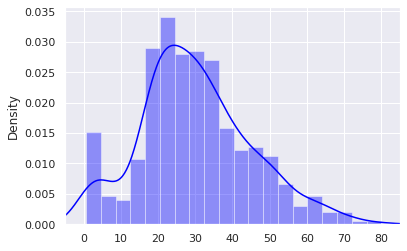

In [11]:
ax = X_train['Age'].hist(bins=20, density=True, stacked=True, color='blue', alpha=0.4)
X_train['Age'].plot(kind='density', color='blue')
plt.xlim(-5,85)

Pelo gráfico podemos perceber que a coluna Age é um pouco assimétrica à direita, assim, usar a média no lugar dos valores nulos pode resultar em resultados enviesados. Para lidar com isso, usaremos a mediana para preencher os valores ausentes.

In [12]:
print('Média da coluna "Age": {:.2f}'.format(X_train['Age'].mean()))
print('Mediana da coluna "Age": {:.2f}'.format(X_train['Age'].median()))

Média da coluna "Age": 30.08
Mediana da coluna "Age": 28.75


### Cabin

In [13]:
# Quantidade de valores nulos em "Cabin"

print('A Porcentagem de valores faltantes em "Cabin" é {:.2f}%'
      .format((X_train['Cabin'].isnull().sum()/X_train.shape[0])*100))

A Porcentagem de valores faltantes em "Cabin" é 78.33%


Devido à grande porcentagem de valores ausentes (78%) nessa coluna, não iremos incluir essa variável no modelo.

### Embarked

In [14]:
# Quantidade de valores nuloes em "Embarked"

print('A Porcentagem de valores faltantes em "Embarked" é {:.2f}%'
      .format((X_train['Embarked'].isnull().sum()/X_train.shape[0])*100))

A Porcentagem de valores faltantes em "Embarked" é 0.16%


Existem apenas 1 valor ausente nesta coluna, assim, vamos apenas inserir a moda da coluna nesse valor

In [15]:
print('O porto de embarque que mais aparece nos dados é {}'.format(X_train['Embarked'].mode()[0]))

O porto de embarque que mais aparece nos dados é S


### SibSp e Parch

De forma a simplificar o modelo, vamos combinar as colunas `SibSp` e `Parch` em uma categoria preditora, de forma que represente se o indivíduo estava viajando sozinho ou não.

### Outras variáveis categóricas

As variáveis categóricas `Pclass` e `Embarked` vamos transformar em dummies, a variável `Sex` transforemos em 1 e 0, onde 1 representa o sexo maculina e 0 o feminino. E escolhemos não utilizar as colunas `Name` e `Ticket`, visto que queremos manter o modelo simples.

## Transformações dos dados de treino

Vamos implementar todas as transformações que discutimos anteriormente

In [16]:
# Preenchendo NaN da coluna Age com a mediana
X_train['Age'].fillna(X_train['Age'].median(), inplace=True)

# Retirando a coluna Cabin por conter muitos valores missing
X_train.drop('Cabin', axis=1, inplace=True)

# Inserindo a mode na coluna Embarked
X_train['Embarked'].fillna(X_train['Embarked'].mode()[0], inplace=True)

# Criando a coluna TravelAlone, representando se a pessoa esta viajando sozinha ou não
X_train['TravelAlone'] = np.where((X_train['SibSp']+X_train['Parch'])==0, 0, 1)
X_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Pegando variáveis dummies
X_train_final = pd.get_dummies(X_train, columns=['Pclass', 'Embarked'])

# Transformando a variável Sex de categórica para numérica
X_train_final['Sex'] = np.where(X_train['Sex']=='female', 0, 1)

# Retirando colunas que não vamos usar no modelo
X_train_final.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [17]:
X_train_final.isnull().sum()

Sex            0
Age            0
Fare           0
TravelAlone    0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [18]:
X_train_final.head()

,Sex,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
114,0,17.00,14.4583,0,0,0,1,1,0,0
874,0,28.00,24.0000,1,0,1,0,1,0,0
76,1,28.75,7.8958,0,0,0,1,0,0,1
876,1,20.00,9.8458,0,0,0,1,0,0,1
674,1,28.75,0.0000,0,0,1,0,0,0,1


## Transformações dos dados de teste

Vamos implementar todas as transformações que discutimos anteriormente nos dados de teste

In [19]:
# Preenchendo NaN da coluna Age com a mediana
X_test['Age'].fillna(X_train['Age'].median(), inplace=True)

# Retirando a coluna Cabin por conter muitos valores missing
X_test.drop('Cabin', axis=1, inplace=True)

# Inserindo a mode na coluna Embarked
X_test['Embarked'].fillna(X_train['Embarked'].mode()[0], inplace=True)

# Criando a coluna TravelAlone, representando se a pessoa esta viajando sozinha ou não
X_test['TravelAlone'] = np.where((X_test['SibSp']+X_test['Parch'])==0, 0, 1)
X_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Pegando variáveis dummies
X_test_final = pd.get_dummies(X_test, columns=['Pclass', 'Embarked'])

# Transformando a variável Sex de categórica para numérica
X_test_final['Sex'] = np.where(X_test['Sex']=='female', 0, 1)

# Retirando colunas que não vamos usar no modelo
X_test_final.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [20]:
X_test_final.isnull().sum()

Sex            0
Age            0
Fare           0
TravelAlone    0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [21]:
X_test_final.head()

,Sex,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
862,0,48.00,25.9292,0,1,0,0,0,0,1
223,1,28.75,7.8958,0,0,0,1,0,0,1
84,0,17.00,10.5000,0,0,1,0,0,0,1
680,0,28.75,8.1375,0,0,0,1,0,1,0
535,0,7.00,26.2500,1,0,1,0,0,0,1


# Regressão Logística

In [22]:
logreg = Pipeline(steps=[('scaler', StandardScaler()),
                        ('logistic', LogisticRegression())])

In [23]:
param_grid = {'logistic__C': np.arange(1e-5, 3, 0.1)}
logreg_cv = GridSearchCV(logreg, param_grid=param_grid, cv=10)

logreg_cv.fit(X_train_final, y_train)

# Verifica os melhores parametros e melhor acuracia
print("Parametros: {}".format(logreg_cv.best_params_))
print("Melhor score: {}".format(logreg_cv.best_score_))

Parametros: {'logistic__C': 0.90001}
Melhor score: 0.8106502816180235


In [24]:
predictions = logreg_cv.predict(X_test_final)

In [25]:
def plot_cm(y, pred):
    ax = sns.heatmap(confusion_matrix(y, pred), fmt='.0f', annot=True, cmap='Blues')

    ax.set_title('Matriz de confusão\n');
    ax.set_xlabel('\nValores Previstos')
    ax.set_ylabel('Valores Reais');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

In [26]:
# computa probabilidades
y_pred_prob = logreg_cv.predict_proba(X_test_final)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

def plot_roc(y, fpr, tpr):
    # Gera fpr, tpr e thresholds    
    # curva ROC
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.xlabel('\nTaxa de falsos positivos')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('ROC Curve\n')
    plt.legend(loc="lower right")
    plt.show()

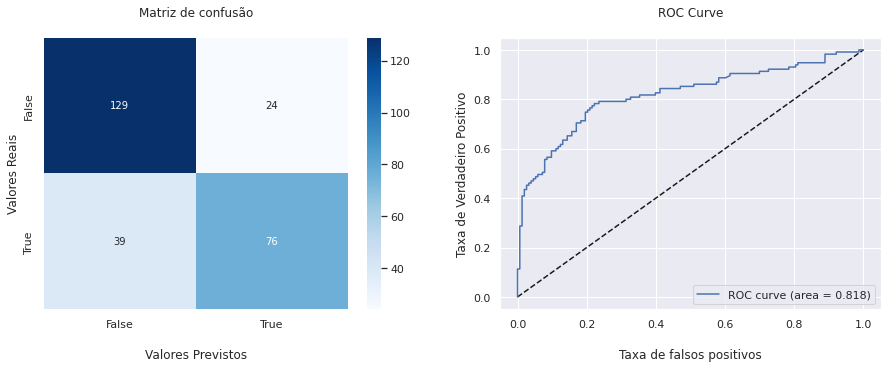

accurace: 0.7649253731343284
f1-score: 0.7069767441860464
recall: 0.6608695652173913
precision: 0.76


In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_cm(y_test, predictions)
plt.subplot(1,2,2)
plot_roc(y_test, fpr, tpr)
#plt.tight_layout()

print('accurace: {}'.format(accuracy_score(y_test, predictions)))
print('f1-score: {}'.format(f1_score(y_test, predictions)))
print('recall: {}'.format(recall_score(y_test, predictions)))
print('precision: {}'.format(precision_score(y_test, predictions)))

# Arvores de Decisão

## Critério Gini

In [28]:
tree_gini = Pipeline(steps=[('scaler', StandardScaler()),
                           ('tree', DecisionTreeClassifier(criterion='gini', random_state=0))])

params = {'tree__max_leaf_nodes': list(range(2, 100)), 'tree__min_samples_split': [2, 3, 4]}

tree_gini_cv = GridSearchCV(tree_gini,
                            param_grid=params, cv=10)

tree_gini_cv.fit(X_train_final, y_train)

# Verifica os melhores parametros e melhor acuracia
print("Parametros: {}".format(tree_gini_cv.best_params_))
print("Melhor score: {}".format(tree_gini_cv.best_score_))

Parametros: {'tree__max_leaf_nodes': 10, 'tree__min_samples_split': 2}
Melhor score: 0.8427291346646184


In [29]:
predictions_gini = tree_gini_cv.predict(X_test_final)

In [30]:
# computa probabilidades
y_pred_prob = tree_gini_cv.predict_proba(X_test_final)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

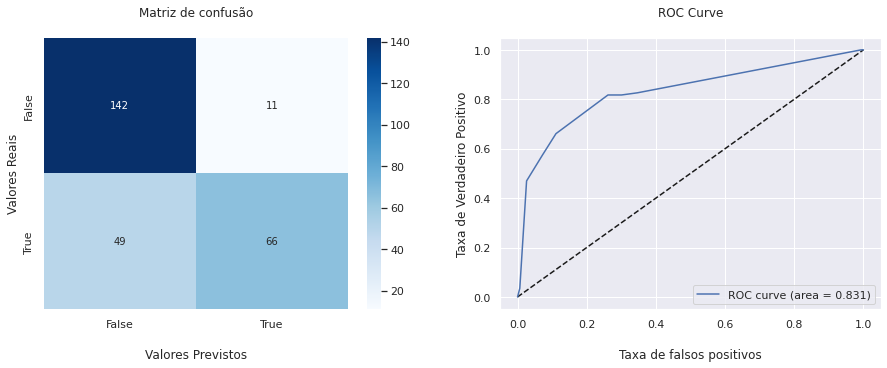

accurace: 0.7761194029850746
f1-score: 0.6875000000000001
recall: 0.5739130434782609
precision: 0.8571428571428571


In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_cm(y_test, predictions_gini)
plt.subplot(1,2,2)
plot_roc(y_test, fpr, tpr)
#plt.tight_layout()

print('accurace: {}'.format(accuracy_score(y_test, predictions_gini)))
print('f1-score: {}'.format(f1_score(y_test, predictions_gini)))
print('recall: {}'.format(recall_score(y_test, predictions_gini)))
print('precision: {}'.format(precision_score(y_test, predictions_gini)))

## Entropia

In [32]:
tree_entr = Pipeline(steps=[('scaler', StandardScaler()),
                           ('tree', DecisionTreeClassifier(criterion='entropy', random_state=0))])

params = {'tree__max_leaf_nodes': list(range(2, 100)), 'tree__min_samples_split': [2, 3, 4]}

tree_entr_cv = GridSearchCV(tree_entr,
                            param_grid=params, cv=10)

tree_entr_cv.fit(X_train_final, y_train)

# Verifica os melhores parametros e melhor acuracia
print("Parametros: {}".format(tree_entr_cv.best_params_))
print("Melhor score: {}".format(tree_entr_cv.best_score_))

Parametros: {'tree__max_leaf_nodes': 10, 'tree__min_samples_split': 2}
Melhor score: 0.8492063492063491


In [33]:
predictions_entr = tree_entr_cv.predict(X_test_final)

In [34]:
# computa probabilidades
y_pred_prob = tree_entr_cv.predict_proba(X_test_final)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

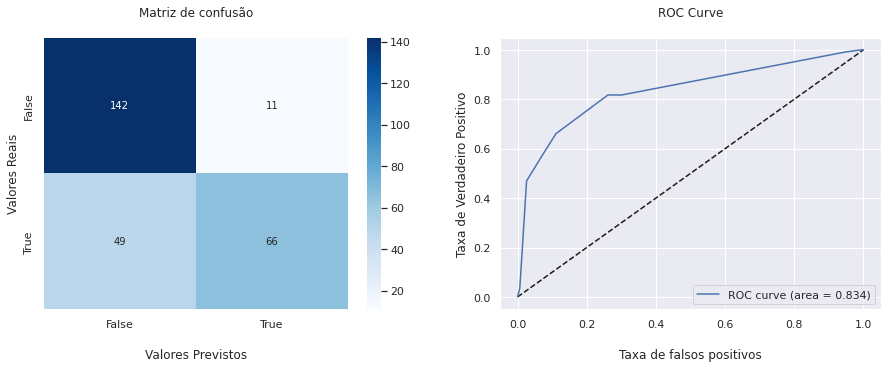

accurace: 0.7761194029850746
f1-score: 0.6875000000000001
recall: 0.5739130434782609
precision: 0.8571428571428571


In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_cm(y_test, predictions_entr)
plt.subplot(1,2,2)
plot_roc(y_test, fpr, tpr)
#plt.tight_layout()

print('accurace: {}'.format(accuracy_score(y_test, predictions_entr)))
print('f1-score: {}'.format(f1_score(y_test, predictions_entr)))
print('recall: {}'.format(recall_score(y_test, predictions_entr)))
print('precision: {}'.format(precision_score(y_test, predictions_entr)))